#### Softmax regression

In this unit, we will see how to perform multiclass classification with the LogisticRegression estimator from Scikit-learn. We will try both the one-vs.-rest (OvR) strategy and the softmax regression model. Again, we will use the iris dataset, but this time, we will create a classifier for the three types of iris flowers.

In [1]:
from sklearn import datasets

# Load dataset
iris = datasets.load_iris()

# Create X/y arrays
X = iris['data'][:, [2, 3]] # Keep only petal features
y = iris['target']

Again, we keep only the petal features (petal length and width) which correspond to columns with index 2 and 3 in the data attribute.

Let’s plot the data. We will use one color for each class

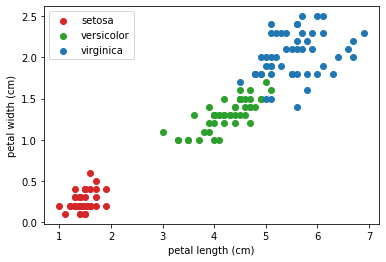

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot data
setosa_idx = (y == 0) # Setosa points
versicolor_idx = (y == 1) # Versicolor points
virginica_idx = (y==2) # Virginica points

plt.scatter(X[:, 0][setosa_idx], X[:, 1][setosa_idx], c='C3', label='setosa')
plt.scatter(X[:, 0][versicolor_idx], X[:, 1][versicolor_idx], c='C2', label='versicolor')
plt.scatter(X[:, 0][virginica_idx], X[:, 1][virginica_idx], c='C0', label='virginica')

# Set labels
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend()
plt.show()

Again, we will use the train/test set methodology to evaluate our classifierm

In [4]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=0)

#### Multiclass logistic regression with OvR
By default, the LogisticRegression estimator uses the one-vs.-rest (OvR) strategy for multiclass classification in all Scikit-learn versions prior to version 0.22. The later versions use softmax regression by default.



In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create the estimator through pipeline
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(multi_class='ovr', solver='liblinear'))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set (evaluation on test)
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.800


In this code, we create the classifier, fit it to the train data and evaluate it on the test set. We get an accuracy around 80%. We can see on the plot from above that each category occupies a different region. The separation between versicolor and virginica flowers is not entirely clear, but we should be able to create a classifier with an accuracy close to 100%.

The issue comes from the **regularization term**. By default, Scikit-learn adds an 
L
2
 term to the loss function of the logistic model. In our case, the regularization strength is too large and our model is underfitting. It’s not possible to remove this regularization term from the LogisticRegression object, but we can reduce its impact with the C parameter which is the inverse of the regularization strength.



In [7]:
# Create the estimator
logreg = make_pipeline(
    # C: inverse of regularization strength
    StandardScaler(), LogisticRegression(C=1000, multi_class='ovr', solver='liblinear'))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.978


Some estimators from Scikit-learn such as RidgeRegression provide an alpha parameter and others provide the C one. In fact, these parameters are two alternative ways to think about regularization. In the previous course, we saw that we can control the regularization strength by multiplying the penalization term with an α parameter.

loss + α * penalization

Alternatively, we can control the weight of the loss function by multiplying it by a C parameter.

C∗loss + penalization

In this second formulation, C controls the weight of the loss function. In the code from above, we set it to a thousand which means that the penalization term has a small impact on the overall loss value, and we get an accuracy around 98%.

We can now use our logreg estimator to classify new data points.

In [10]:
# New flower
new_flower = [
    5, # petal length (cm)
    1.5, # petal width (cm)
]

# Predict probabilities (there is a classifier for each class that estimates the probability that new data points belongs to it.)
logreg.predict_proba([new_flower])


array([[8.62023737e-08, 5.51329272e-01, 4.48670642e-01]])

In our example, the second category has the largest probability with p=0.55 and the point is classified as a versicolor iris flower. We can verify that using the predict() function



In [12]:
# Predict class with highest probability
#In this case, it returns 1 which is the numerical label of the versicolor category in the target vector.
logreg.predict([new_flower])

array([1])

We can use the predict() function to plot the decision boundaries of our classifier. To achieve this, we implemented a decision_boundaries(X, y, logreg) function in the annex below. In short, it generates a grid of values in the range of our X/y data and predicts their labels using the predict() function from our logreg estimator.



In [13]:
import numpy as np

# Helper function
def decision_boundaries(ax, X, y, logreg):
    # Plot data
    setosa_idx = (y == 0) # Setosa points
    versicolor_idx = (y == 1) # Versicolor points
    virginica_idx = (y==2) # Virginica points

    plt.scatter(X[:, 0][setosa_idx], X[:, 1][setosa_idx], c='C3', label='setosa')
    plt.scatter(X[:, 0][versicolor_idx], X[:, 1][versicolor_idx], c='C2', label='versicolor')
    plt.scatter(X[:, 0][virginica_idx], X[:, 1][virginica_idx], c='C0', label='virginica')

    # Create a grid of values
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    xpoints = np.linspace(*xlim, num=1000)
    ypoints = np.linspace(*ylim, num=1000)
    xx, yy = np.meshgrid(xpoints, ypoints)

    # Compute predictions
    preds = logreg.predict(np.c_[xx.flatten(), yy.flatten()])

    # Plot boundaries between classes 1-2 and 2-3
    zz = preds.reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=[0.5, 1.5],
                colors=['C3', 'C0'], linestyles='dashed')

    # Add labels
    plt.xlabel('petal length (cm)')
    plt.ylabel('petal width (cm)')
    plt.legend(loc='lower right')
    plt.show()

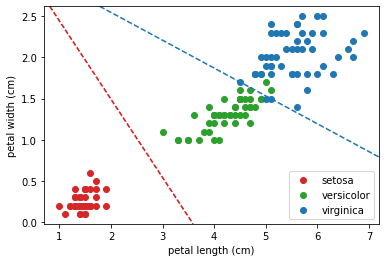

In [14]:
# Plot boundaries
fig = plt.figure()
decision_boundaries(fig.gca(), X, y, logreg)

#### Softmax regression


It’s also possible to use softmax regression, also known as multinomial logistic regression, with LogisticRegression by setting the multi_class parameter to multinomial. So far, we used liblinear to fit our logistic regressions. However, this solver doesn’t support the softmax variant



In [16]:
# Create the estimator
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(multi_class='multinomial', solver='liblinear'))

# Fit it to train data
try:
    logreg.fit(X_tr, y_tr)
except Exception as e:
    print(e) # Solver liblinear does not support a multinomial backend.


Solver liblinear does not support a multinomial backend.


In [17]:
# Create the estimator with stochastic solver (useful in OvR and softmax)
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(multi_class='multinomial', solver='saga'))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy)) # Prints: 0.956

Accuracy: 0.956


This time, we get an accuracy around 96% which is a bit lower than with the OvR strategy from above. Again, we can plot the decision boundaries with the decision_boundaries() function

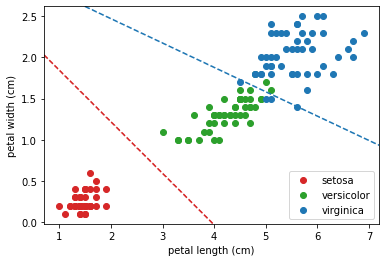

In [18]:
# Plot boundaries
fig = plt.figure()
decision_boundaries(fig.gca(), X, y, logreg)

Let’s try to decrease the regularization by increasing C



In [19]:
# Create the estimator
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(C=10, multi_class='multinomial', solver='saga'))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.978


This time, we get an accuracy around 98% and slightly different the decision boundaries



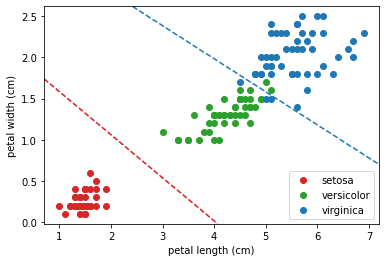

In [21]:
# Plot boundaries
fig = plt.figure()
decision_boundaries(fig.gca(), X, y, logreg)

#### Summary
Let’s summarize what we’ve learned in this unit. Here are a few takeaways.

* In Scikit-learn (versions prior to 0.22), LogisticRegression uses OvR for multiclass classification by default. In later versions, softmax regression is the default option
* By default, LogisticRegression adds an L2 penalization term. We can control its weight with the C parameter
* In Scikit-learn (versions prior to 0.22), the default solver for LogisticRegression is liblinear which doesn’t support softmax regression, but we can manually change the solver to saga for example. In later versions, the default solver supports softmax regression